# Tasks 1 and 2

### Preparation

Download Computed Tomography Images for Intracranial Hemorrhage Detection and Segmentation from physionet

In [60]:
# !wget -r -N -c -np --user flusspilot --ask-password https://physionet.org/files/ct-ich/1.3.1/

In [1]:
import os
import random
from pprint import pprint
from sklearn.metrics import roc_curve, auc

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import cv2
#from mlxtend.plotting import plot_decision_regions
from IPython.display import display, clear_output

### Task 1.1 - Research Question

**Can the combination of demographic factors and texture features (e.g. Local Binary Patterns) improve the accuracy and reliability of hemorrhage detection in CT scans?**

The research question aims to explore the potential relationship and impact of combining demographic factors and texture features on hemorrhage detection. It seeks to uncover new insights and understand the potential benefits of this combination. By examining the joint influence of demographic factors and texture descriptors, we can gain a deeper understanding of how these variables interact and contribute to the accuracy and reliability of hemorrhage detection in CT scans.

Once this exploratory phase establishes promising results and demonstrates the potential advantages of the combined approach, the research could be extended to a predictive stage. In the predictive phase, the focus would shift towards developing models or algorithms that leverage the combined demographic and texture features to predict hemorrhage presence, severity, or other relevant outcomes in unseen CT scans. This extension would involve training and testing predictive models, evaluating their performance, and potentially refining the approach to optimize its predictive capabilities.

In summary, the initial exploration would lay the foundation for further predictive research by demonstrating the potential of the combined approach in improving hemorrhage detection and characterization.

### Task 1.2 - Load demographics.csv

Load demographics from csv

In [8]:
demographics = pd.read_csv('MedSAM/raw_data/Patient_demographics.csv')

Put all Hemorrhage types in one column

In [9]:
demographics.columns.values[3] = 'Intraventricular'
demographics.columns.values[4] = 'Intraparenchymal'
demographics.columns.values[5] = 'Subarachnoid'
demographics.columns.values[6] = 'Epidural'
demographics.columns.values[7] = 'Subdural'

demographics['Hemorrhage Type'] = None

# Aktualisieren Sie die Werte basierend auf den anderen Spalten
demographics.loc[demographics['Intraventricular'] == '1', 'Hemorrhage Type'] = 'Intraventricular'
demographics.loc[demographics['Intraparenchymal'] == '1', 'Hemorrhage Type'] = 'Intraparenchymal'
demographics.loc[demographics['Subarachnoid'] == '1', 'Hemorrhage Type'] = 'Subarachnoid'
demographics.loc[demographics['Epidural'] == '1', 'Hemorrhage Type'] = 'Epidural'
demographics.loc[demographics['Subdural'] == '1', 'Hemorrhage Type'] = 'Subdural'

demographics['Hemorrhage Type'] = demographics['Hemorrhage Type'].replace({np.nan: 'No Hemorrhage'})

columns_to_drop = ['Intraventricular', 'Intraparenchymal', 'Subarachnoid', 'Epidural', 'Subdural']
demographics = demographics.drop(columns=columns_to_drop)

demographics.head()

Patient Number  Age\n(years)  Gender  Fracture (yes 1/no 0) Note1  \
0             NaN           NaN     NaN                    NaN   NaN   
1            49.0        35.000    Male                    1.0   NaN   
2            50.0         0.583  Female                    1.0   NaN   
3            51.0         5.000    Male                    1.0   NaN   
4            52.0         8.000    Male                    1.0   NaN   

    Hemorrhage Type  
0     No Hemorrhage  
1          Epidural  
2  Intraparenchymal  
3          Subdural  
4          Epidural

In [10]:
demographics = demographics.rename(columns={'Note1': 'Note',
                                            'Age\n(years)': 'Age',
                                            'Fracture (yes 1/no 0)': 'Fracture'})

demographics["Fracture"] = demographics["Fracture"].replace({1.0: True, np.nan: False})

demographics.head()

Patient Number     Age  Gender  Fracture Note   Hemorrhage Type
0             NaN     NaN     NaN     False  NaN     No Hemorrhage
1            49.0  35.000    Male      True  NaN          Epidural
2            50.0   0.583  Female      True  NaN  Intraparenchymal
3            51.0   5.000    Male      True  NaN          Subdural
4            52.0   8.000    Male      True  NaN          Epidural

In [11]:
demographics = demographics.drop(0)  # First row seems to be a error in the data
demographics = demographics.drop([83,84])  # Same for last two rows

demographics.head()

Patient Number     Age  Gender  Fracture Note   Hemorrhage Type
1            49.0  35.000    Male      True  NaN          Epidural
2            50.0   0.583  Female      True  NaN  Intraparenchymal
3            51.0   5.000    Male      True  NaN          Subdural
4            52.0   8.000    Male      True  NaN          Epidural
5            53.0  44.000    Male      True  NaN          Epidural

We have 82 subjects

In [12]:
print(len(demographics))

82


### Task 1.3 - Number of Features

Since the Patient Number is less a feature and more an identifier, and the Note cannot be processed automatically, 5 features remain:

- Age
- Gender
- Fracture
- Hemorrhage Type

As we have 82 patients, this, together with the patient number and the Note, results in a 82x6 matrix.

### Task 1.4 - Types of Features

| Feature | Type        |
|--------|-------------|
| Age | Numerical   |
| Gender | Categorical |
| Fracture | Categorical |
Hemorrhage Type | Categorical |

### Task 1.5 - Summary of Dataset

In [18]:
print("Subjects: " + str(len(demographics)))

Subjects: 82


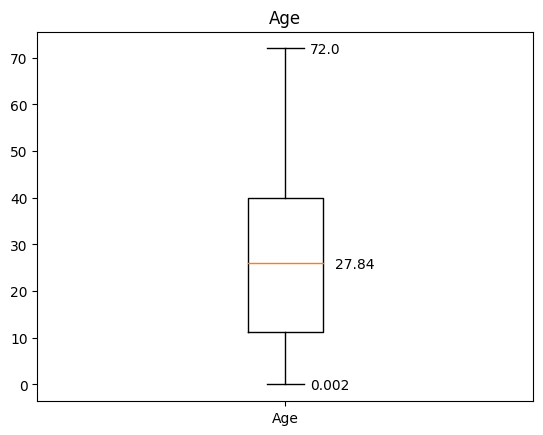

In [19]:
boxplot = plt.boxplot(demographics["Age"])
whisker_min = boxplot["whiskers"][0].get_ydata()[1]
whisker_max = boxplot["whiskers"][1].get_ydata()[1]
plt.text(1.05, whisker_min-0.1, f"{whisker_min}", va="center")
plt.text(1.05, whisker_max-0.1, f"{whisker_max}", va="center")

mean_age = demographics["Age"].mean()
plt.text(1.1, mean_age-2, f"{mean_age:.2f}", va="center")

plt.xticks([1], ["Age"])
plt.title("Age")
plt.show()

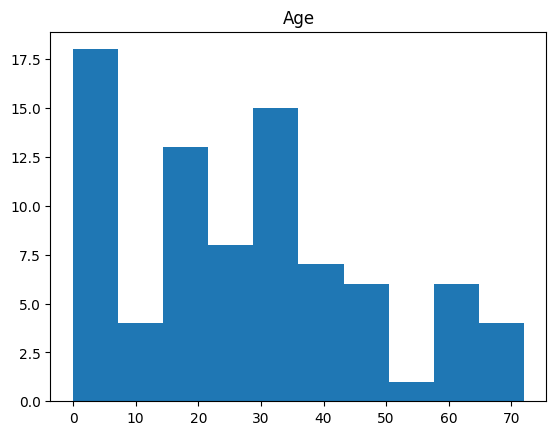

In [20]:
histogram = plt.hist(demographics["Age"])

plt.title("Age")
plt.show()

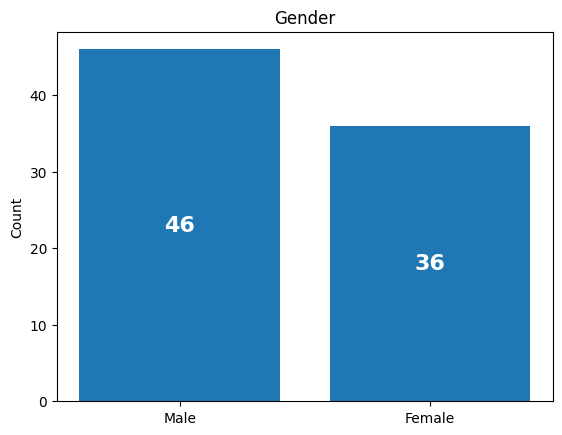

In [21]:
counts = demographics["Gender"].value_counts(dropna=False)

plt.bar(counts.index, counts.values)

for i, count in enumerate(counts.values):
    plt.text(i, count/2, str(count), ha='center', va='center', color='white', fontsize=16, weight='bold')

plt.title("Gender")
plt.ylabel("Count")

plt.show()

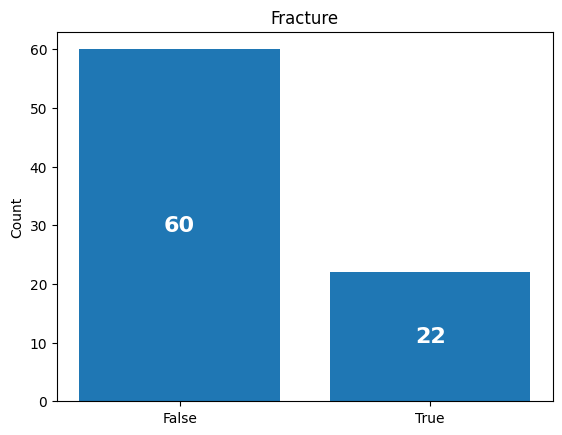

In [22]:
counts = demographics["Fracture"].value_counts(dropna=False)

plt.bar(counts.index, counts.values)

for i, count in enumerate(counts.values):
    plt.text(i, count/2, str(count), ha='center', va='center', color='white', fontsize=16, weight='bold')

plt.title("Fracture")
plt.ylabel("Count")
plt.xticks(range(len(counts)), ["False", "True"])

plt.show()

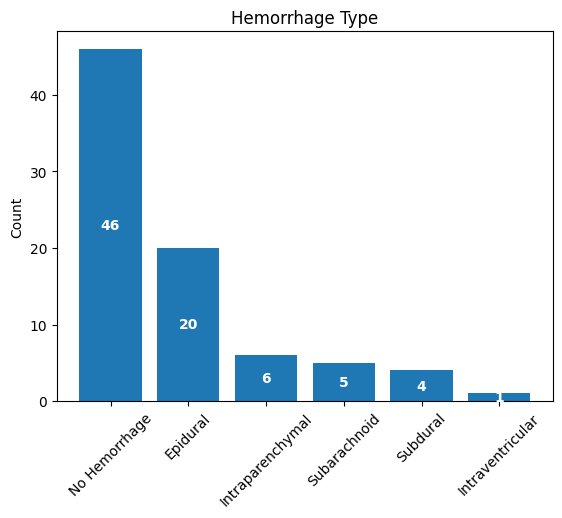

In [23]:
counts = demographics["Hemorrhage Type"].replace({np.nan: "No Hemorrhage"}).value_counts()

plt.bar(counts.index, counts.values)

for i, count in enumerate(counts.values):
    plt.text(i, count / 2, str(count), ha='center', va='center', color='white', fontsize=10, weight='bold')

plt.title("Hemorrhage Type")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.show()

### Task 1.6 - Missing values

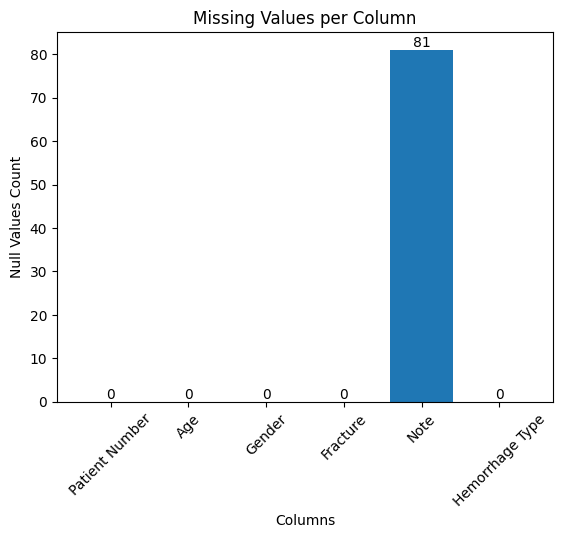

In [24]:
null_counts = demographics.isnull().sum()

plt.bar(null_counts.index, null_counts.values)

for i, count in enumerate(null_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.title("Missing Values per Column")
plt.xlabel("Columns")
plt.ylabel("Null Values Count")
plt.xticks(rotation=45)

plt.show()

I already replaced the missing values in the Fracture Column with False:

-> demographics["Fracture"] = demographics["Fracture"].replace({1.0: True, np.nan: False})

### Task 1.7 - Type of missing values

The missing values in the Note Column are negligible. They contain free text (string) for only one patient; the remaining patients do not have any recorded notes or abnormalities.

### Task 1.8 - Imputation

Imputation is not necessary, see 1.7.

### Task 1.9 - Transformations

We drop the Note column. It does not provide relevant information for our machine learning task

In [26]:
demographics = demographics.drop('Note', axis=1)

One Hot Encoding of Gender column (see 2.1)
One Hot Encoding of Hemorrhage Type column (see 2.1)
Binning the Age column could be useful (see 2.1)

In [27]:
demographics

Patient Number     Age  Gender  Fracture   Hemorrhage Type
1             49.0  35.000    Male      True          Epidural
2             50.0   0.583  Female      True  Intraparenchymal
3             51.0   5.000    Male      True          Subdural
4             52.0   8.000    Male      True          Epidural
5             53.0  44.000    Male      True          Epidural
..             ...     ...     ...       ...               ...
78           126.0  58.000  Female     False     No Hemorrhage
79           127.0   5.000    Male     False     No Hemorrhage
80           128.0  32.000  Female     False     No Hemorrhage
81           129.0   5.000  Female     False     No Hemorrhage
82           130.0  24.000  Female     False     No Hemorrhage

[82 rows x 5 columns]

In [239]:
demographics.to_csv('demographics_processed.csv', index=False)

### Task 1.10 - Plot CT Scan

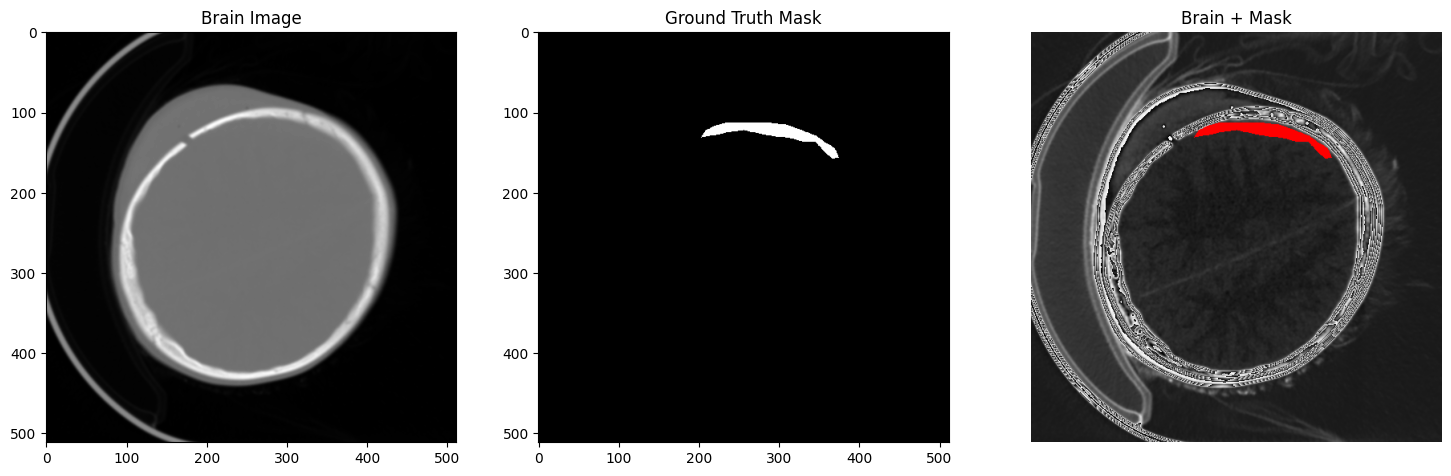

In [56]:
patient_number = 51
slice = 33

brain_path = f"MedSAM/raw_data/ct_scans/{str(patient_number).zfill(3)}.nii"
mask_path = f"MedSAM/raw_data/masks/{str(patient_number).zfill(3)}.nii"

brain_image = nib.load(brain_path).get_fdata()
mask_image = nib.load(mask_path).get_fdata()

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

brain_slice = brain_image[:, :, slice]
mask_slice = mask_image[:, :, slice]

#for i in range(mask_image.shape[2]):
#    print(str(i), max(mask_image[:, :, i].flatten()))

axs[0].imshow(brain_slice, cmap="gray")
axs[0].set_title("Brain Image")

axs[1].imshow(mask_slice, cmap="gray")
axs[1].set_title("Ground Truth Mask")

# Overlay-Bild erstellen
mask_min = 0
mask_max = 255.0

mask_image_color = cv2.cvtColor(np.uint8(brain_slice), cv2.COLOR_GRAY2BGR)
mask_image_color[mask_slice > 0] = (255, 0, 0)

# Brain-Bild mit Overlay anzeigen
axs[2].imshow(mask_image_color)
axs[2].axis("off")
axs[2].set_title("Brain + Mask")

plt.show()

### Task 1.11 - Size of CT Scan

In [64]:
num_slices = np.array([nib.load(f"MedSAM/raw_data/masks/{path}").get_fdata().shape[2] for path in os.listdir("MedSAM/raw_data/masks")])

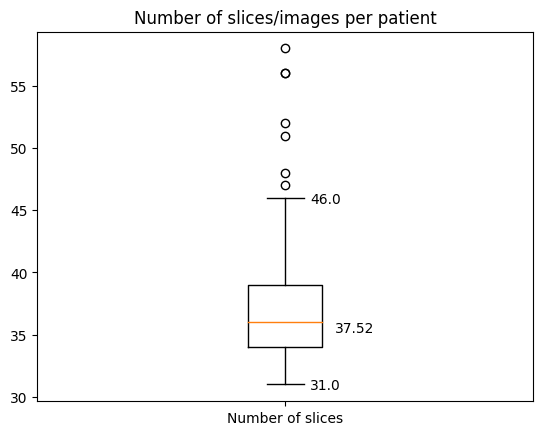

In [65]:
boxplot = plt.boxplot(num_slices)
whisker_min = boxplot["whiskers"][0].get_ydata()[1]
whisker_max = boxplot["whiskers"][1].get_ydata()[1]
plt.text(1.05, whisker_min-0.1, f"{whisker_min}", va="center")
plt.text(1.05, whisker_max-0.1, f"{whisker_max}", va="center")

mean_age = num_slices.mean()
plt.text(1.1, mean_age-2, f"{mean_age:.2f}", va="center")

plt.xticks([1], ["Number of slices"])
plt.title("Number of slices/images per patient")
plt.show()

In [62]:
patient_number = 49
brain_path = f"MedSAM/raw_data/masks/0{patient_number}.nii"

brain_image = nib.load(brain_path)
brain_data = brain_image.get_fdata()

image_shape = brain_data.shape
print("Height:", image_shape[0])
print("Width:", image_shape[1])

Height: 512
Width: 512


The images have a width and height of 512x512 pixel. For each patient there are about 37 scans

### Task 1.12 - Transformation of CT Scans

**Windowing:**: I have no domain knowledge in CT imaging, but from the website [radiopaedia](https://radiopaedia.org/articles/windowing-ct) I have learned that so-called windowing could be a useful transformation for our experiments. Windowing is a transformation technique used in the analysis of CT images. By adjusting the display range of pixel intensities, it enhances the visibility of specific structures and abnormalities, allowing for improved interpretation and diagnosis. With the help of windowing we can better differentiate between different tissue types.

**Region of Interest (ROI)**: CT scans may contain a large field of view, including irrelevant areas outside the region of interest. Cropping or extracting the relevant region (the brain) can reduce irrelevant or misleading information.

**Noise Reduction:** CT scans may exhibit noise, which can impact subsequent analysis. Applying noise reduction or smoothing techniques, such as Gaussian filtering or median filtering, can help enhance image quality and remove unwanted artifacts.

In [1]:
# Code from MedSAM repository

def window_ct (ct_scan, w_level=40, w_width=80):
    w_min = w_level - w_width / 2
    w_max = w_level + w_width / 2
    num_slices=ct_scan.shape[2]

    for s in range(num_slices):
        slice_s = ct_scan[:,:,s]
        slice_s = (slice_s - w_min)*(255/(w_max-w_min))
        slice_s[slice_s < 0]=0
        slice_s[slice_s > 255] = 255
        ct_scan[:,:,s] = slice_s

    return ct_scan

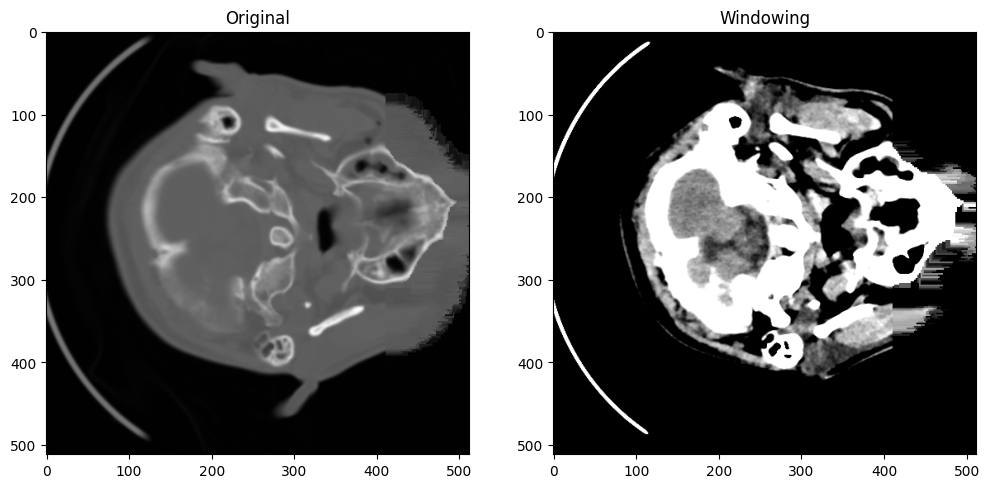

In [94]:
patient_number = 49
brain_path = f"MedSAM/raw_data/ct_scans/0{patient_number}.nii"

brain_image = nib.load(brain_path).get_fdata()
windowed_brain_image = window_ct(brain_image.copy(), w_level=40, w_width=80)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(brain_image[:,:,5], cmap="gray")
axs[0].set_title("Original")

axs[1].imshow(windowed_brain_image[:,:,5], cmap="gray")
axs[1].set_title("Windowing")

plt.show()

---

### Task 2.1 - Predict Hemorrhage Probability

In [95]:
demographics

Patient Number     Age  Gender  Fracture   Hemorrhage Type
1             49.0  35.000    Male      True          Epidural
2             50.0   0.583  Female      True  Intraparenchymal
3             51.0   5.000    Male      True          Subdural
4             52.0   8.000    Male      True          Epidural
5             53.0  44.000    Male      True          Epidural
..             ...     ...     ...       ...               ...
78           126.0  58.000  Female     False     No Hemorrhage
79           127.0   5.000    Male     False     No Hemorrhage
80           128.0  32.000  Female     False     No Hemorrhage
81           129.0   5.000  Female     False     No Hemorrhage
82           130.0  24.000  Female     False     No Hemorrhage

[82 rows x 5 columns]

In [96]:
# Gender OHE

gender_one_hot = pd.get_dummies(demographics['Gender'])
demographics = pd.concat([demographics, gender_one_hot], axis=1)
demographics = demographics.drop('Gender', axis=1)

In [97]:
# Hemorrhage Type OHE

hemorrhage_one_hot = pd.get_dummies(demographics['Hemorrhage Type'])
demographics = pd.concat([demographics, hemorrhage_one_hot], axis=1)
demographics = demographics.drop('Hemorrhage Type', axis=1)

In [98]:
# Age Binning

bins = list(range(0, 80, 10)) + [float('inf')]
age_groups = [f'{bins[i]}-{bins[i+1]-1}' for i in range(len(bins)-1)]
age_groups[-1] = f'{bins[-2]}+'

demographics['Age Group'] = pd.cut(demographics['Age'], bins=bins, labels=age_groups)

# Age Binning (OHE)

age_one_hot = pd.get_dummies(demographics['Age Group'])
demographics = pd.concat([demographics, age_one_hot], axis=1)

Since Male / Female are 100% dependent we drop Female

In [100]:
demographics.head()

Patient Number     Age  Fracture  Female   Male  Epidural  \
1            49.0  35.000      True   False   True      True   
2            50.0   0.583      True    True  False     False   
3            51.0   5.000      True   False   True     False   
4            52.0   8.000      True   False   True      True   
5            53.0  44.000      True   False   True      True   

   Intraparenchymal  Intraventricular  No Hemorrhage  Subarachnoid  Subdural  \
1             False             False          False         False     False   
2              True             False          False         False     False   
3             False             False          False         False      True   
4             False             False          False         False     False   
5             False             False          False         False     False   

  Age Group    0-9  10-19  20-29  30-39  40-49  50-59  60-69    70+  
1     30-39  False  False  False   True  False  False  False  False  
2       0-9   True  False  False  False  False  False  False  False  
3       0-9   True  False  False  False  False  False  False  False  
4       0-9   True  False  False  False  False  False  False  False  
5     40-49  False  False  False  False   True  False  False  False

Target column:

In [102]:
y = demographics['No Hemorrhage']

In [121]:
def mean_absolute_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred))

def root_mean_squared_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

##### Age (binned), Fracture, Gender (OHE)

Since Male / Female are 100% dependent we only use Male

In [225]:
used_features = ['Fracture', 'Male'] + age_groups

X = demographics[used_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred_prob.round())
mae = mean_absolute_error(y_test, y_pred_prob)
rmse = root_mean_squared_error(y_test, y_pred_prob)

print(f"Accuracy: {accuracy}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

Accuracy: 0.7058823529411765
MAE: 0.34857045025025724
RMSE: 0.43475592076242353


In [219]:
random_unseen_patient = X_test.sample(n=1)

prediction = model.predict(random_unseen_patient)[0]

if prediction:
    print("Model predicted: No Hemorrhage")
else:
    print("Model predicted: Hemorrhage")

Model predicted: Hemorrhage


##### Age, Fracture, Gender (OHE)

In [236]:
used_features = ['Age', 'Fracture', 'Male']

X = demographics[used_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred_prob.round())
mae = mean_absolute_error(y_test, y_pred_prob)
rmse = root_mean_squared_error(y_test, y_pred_prob)

print(f"Accuracy: {accuracy}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

Accuracy: 0.7647058823529411
MAE: 0.28956277553952364
RMSE: 0.3343726674495256


In [227]:
random_unseen_patient = X_test.sample(n=1)

prediction = model.predict(random_unseen_patient)[0]

if prediction:
    print("Model predicted: No Hemorrhage")
else:
    print("Model predicted: Hemorrhage")

Model predicted: Hemorrhage


### Task 2.2 - Beta Coefficients

In [237]:
beta_coefficients = model.coef_[0]
regression_line = "logit(p) = " + " + ".join([f"\n{beta:.4f} * {feature}" for beta, feature in zip(beta_coefficients, X.columns)])

print()
print("Beta Coefficients:")
pprint(beta_coefficients)

print("\nExpression of Regression Line:")
print(regression_line)


Beta Coefficients:
array([ 0.00741608, -2.07063989, -1.35618334])

Expression of Regression Line:
logit(p) = 
0.0074 * Age + 
-2.0706 * Fracture + 
-1.3562 * Male


### Task 2.3 - Plot results

Since we have a multi-dimensional problem, we cannot easily plot the regression line as we could in a simple x vs. y scenario. We can, however, plot the ROC Curve for an intuitive visualisation of the model performance.

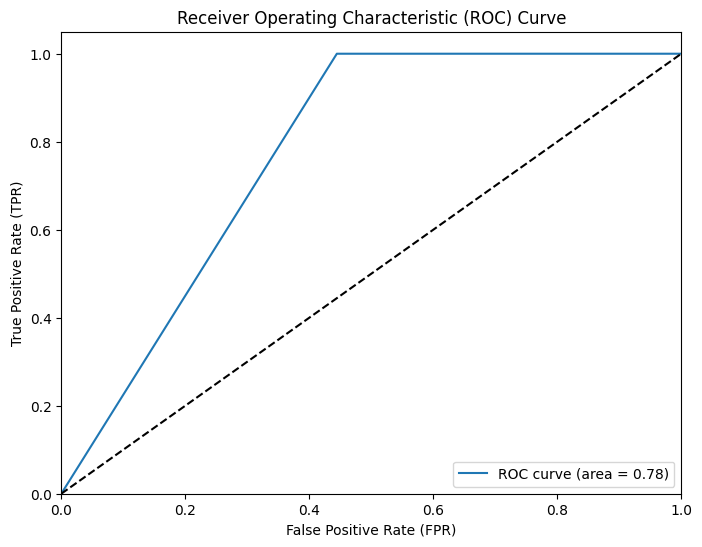

In [238]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob.round())

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Plot the random classifier line

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Task 2.4 - MAE and RMSE

In [222]:
accuracy = accuracy_score(y_test, y_pred_prob.round())
mae = mean_absolute_error(y_test, y_pred_prob)
rmse = root_mean_squared_error(y_test, y_pred_prob)

print(f"Accuracy: {accuracy}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

Accuracy: 0.8235294117647058
MAE: 0.28066602222105974
RMSE: 0.36324429100504413


Values change between runs because of the random state.


**Accuracy**: 0.8235294117647058
- The accuracy is a measure of the overall correctness of the predictions. In this case, an accuracy of 0.8235... suggests that the model's predictions were correct for approximately 88.23% of the cases evaluated.

**MAE (Mean Absolute Error)**: 0.28066602222105974
- MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. Lower values indicate better performance. A MAE of 0.2806 is relatively low.

**RMSE (Root Mean Squared Error)**: 0.36324429100504413
- RMSE is a quadratic scoring rule that also measures the average magnitude of the error. Lower values indicate better performance. The errors are squared before they are averaged, making the RMSE sensitive to large errors --> predicting 0.8 instead of 0 is far "worse" than predicting 0.2